In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import time
from skimage.metrics import structural_similarity as ssim
import os
import copy
import cv2
from IPython.display import Image 
from google.colab.patches import cv2_imshow
from torch.optim import lr_scheduler
from torch.utils.data.dataset import Dataset
from skimage import io, transform
from PIL import Image, ImageOps
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.6.0+cu101
Torchvision Version:  0.7.0+cu101


In [3]:
# Model definition

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True))   

class UNet(nn.Module):
    def __init__(self):
        super().__init__()                
        self.dconv_down1 = double_conv(1, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)        
        self.conv_last = nn.Conv2d(64,1, 1)
        self.sig_act = nn.Sigmoid()
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)
        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)        
        x = self.dconv_down4(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)  
        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)         
        x = self.dconv_up1(x)
        out = self.conv_last(x)
        out = self.sig_act(out)
        return out

def unet(pretrained=False, progress=True, **kwargs):
    model = UNet(**kwargs)
    return model

In [30]:
test_image_path = './drive/My Drive/AML_assignments/Test_images/set2/'
test_mask_path = './drive/My Drive/AML_assignments/Test_masks/Contours_black_test2set/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = unet()
model.load_state_dict(torch.load('./drive/My Drive/AML_assignments/model_black_1.pt'))
model = model.to(device)
model.eval()


UNet(
  (dconv_down1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kerne

In [31]:
class RV_Data_test(Dataset):
    def __init__(self, path, transforms=None):
        self.path = path
        self.list = os.listdir(self.path)   
        self.transforms = transforms
        
    def __getitem__(self, index):
        # stuff
        image_path = test_image_path
        mask_path = test_mask_path
        image = Image.open(image_path+self.list[index])
        mask = Image.open(mask_path+self.list[index])
        if self.transforms is not None:
            image = self.transforms(image)
            mask = self.transforms(mask)
            return (image,mask)

    def __len__(self):
        return len(self.list)

In [32]:
# test data generator
params = {'batch_size': 16,
          'shuffle': True,
          'num_workers': 0}
transform = transforms.Compose([transforms.Resize((216,216)), transforms.Grayscale(), transforms.ToTensor()
                                   ]) 
test_set = RV_Data_test(test_image_path,transform)
test_generator = torch.utils.data.DataLoader(test_set, **params)


In [33]:
print('Length of test dataset is:', len(test_set))
print('Length of test dataloader is:', len(test_generator))

Length of test dataset is: 252
Length of test dataloader is: 16


In [34]:
#PyTorch
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()
 
    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = F.sigmoid(inputs)     
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
 
        return (1 - dice_loss)

In [40]:
criterion = DiceLoss()
running_loss = 0
for image, mask in test_generator:

    image, mask = image.to(device), mask.to(device)
    
    output = model(image)
    loss = criterion(output, mask)
    running_loss += loss.item()

# print statistics
avg_test_loss = running_loss/ len(test_generator)
print('{} Loss: {:.4f} ' .format('Test', avg_test_loss))

Test Loss: 0.2622 


In [17]:
import random, os

images = []

for i in range(1, 11):

  test_img_path =  './drive/My Drive/AML_assignments/Test_images/set2/'
  random_filename = random.choice([
      x for x in os.listdir(test_img_path)
      if os.path.isfile(os.path.join(test_img_path, x))
      ])
  images.append(random_filename)

In [18]:
print(images)

['P45-0140.jpg', 'P46-0040.jpg', 'P34-0107.jpg', 'P39-0120.jpg', 'P37-0040.jpg', 'P42-0240.jpg', 'P43-0187.jpg', 'P36-0080.jpg', 'P37-0107.jpg', 'P47-0120.jpg']


In [19]:
model_test = unet()
model_test.load_state_dict(torch.load('./drive/My Drive/AML_assignments/model_black_1.pt'))
model_test.eval()

UNet(
  (dconv_down1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kerne

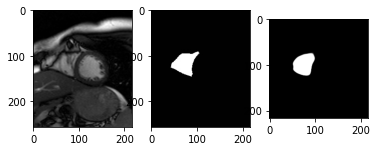

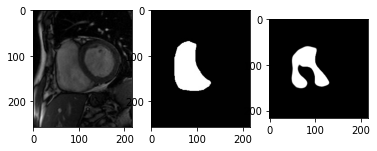

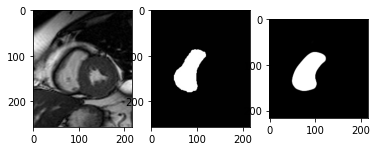

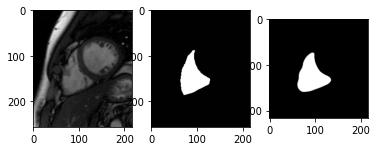

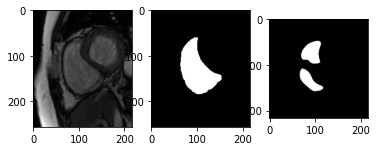

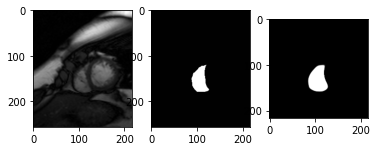

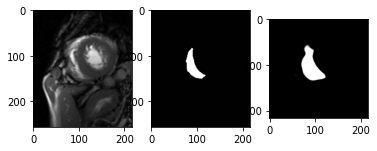

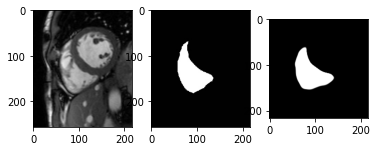

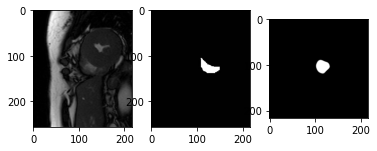

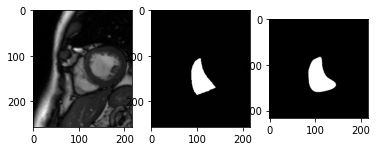

In [20]:
for image in images:
 
  img = Image.open('./drive/My Drive/AML_assignments/Test_images/set2/'+ image)
  target = Image.open('./drive/My Drive/AML_assignments/Test_masks/Contours_black_test2set/'+ image)
  
  trans = transforms.Compose([transforms.Resize((216,216)), transforms.Grayscale(), transforms.ToTensor()
    ])
  inp = trans(img)
  c,h,w = inp.shape
  image = inp.reshape(1,c,h,w)
  out = model_test(image)
  om = out.squeeze().detach().cpu().numpy()
  pred = torch.tensor(om)
   
  f, axarr = plt.subplots(1, 3)
  axarr[0].imshow(img)
  axarr[1].imshow(target)
  axarr[2].imshow(pred, cmap = 'gray')  
